<a href="https://colab.research.google.com/github/ddeMoivre/blog/blob/master/_notebooks/2022_02_09_Time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis of the US Treasury 10- Year Yield

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/Ohlc_chart.png

### AR(p)  Models

A time series model for the observed data $\{x_t\}$ is a specification of the joint distribution (or possibly only the means and covariances) of a sequence of random variables $\{X_t\}$ of which $\{x_t\}$ is postulated to be a realization. 

The causal autoregressive $AR(p)$ process is defined by 
$$
X_t-\phi_1 X_{t-1} - ...-\phi_p X_{t-p}=c + Z_t, \ \ {Z_t} \sim WN(0,\sigma^2).
$$

A time series $\{X_t\}$ is (covariance) **stationnary** if the mean function $\mu_X(t):= E(X_t)$ is independent of $t$, and the autocovariance function (ACVF) of $\{X_t\}$ at lag $h$ 

$$
\gamma_X(t+h,t) := Cov(X_{t+h},X_t) = \mathbb{E}[(X_{t+h}-\mu_X(t+h))(X_{t}-\mu_X(t))]
$$

is independent of $t$ for each $h$.

To assess the degree of dependence in the data and to select a model for the data that reflects this, one of the important tools we use is the sample autocorrelation function (sample ACF) of the data. Let $\{X_t\}$ be a stationary time series. The **autocorrelation function** of $\{X_t\}$ at lag $h$ is 

$$
\rho_X(h):=\frac{\gamma_X(h)}{\gamma_X(0)} = Cor(X_{t+h},X_{t}).
$$

Let $x_1,...,x_n$ be observations of a time series. The **sample autocorrelation function** is 

$$
\hat\rho(h) = \frac{\hat\gamma(h)}{\hat\gamma(0)},
$$

where $\hat\gamma(h)$ is the sample autocovariance function i.e., $\hat\gamma(h): = n^{-1}\sum_{t=1}^{n-|h|}(x_{n-|h|}-\bar{x})(x_t-\bar{x})$, for $\ -n<h<n$ and $\bar{x}:=n^{-1}\sum^n_{t=1} x_t$.

We define sample PACF in an analogous way. If we believe that the data are realized values of a stationary time series $\{X_t\}$, then the sample ACF will provide us with an estimate of the ACF of $\{X_t\}$. This estimate may suggest which of the many possible stationary time series models is a suitable candidate for representing the dependence in the data. For example, a sample ACF that is close to zero for all nonzero lags suggests that an appropriate model for the data might be iid noise.

A **partial autocorrelation function (PACF)** of an ARMA process $\{X_t\}$ is the function $\alpha(\cdot)$ defined by the equations 

$$
\alpha(0) = 1 \ \ \text{and} \ \ \alpha(h) = \phi_{hh}, \ \ h \geq 1,
$$

where $\phi_{hh}$ is the last component of $\Phi_h = \Gamma^{-1}_{h}\gamma_h$, $\Gamma_h$ is $h$-dimensional the covariance matrix and $\gamma_h = [\gamma(1),\gamma(2),...,\gamma(h)]'$.

The partial autocorrelation function is a tool that exploits the fact that, whereas an $AR(p)$ process has an autocorrelation function that is infinite in extent, the partial autocorrelations are zero beyond lag $p$. We define sample PACF for observed data in an analogous way.

#### Reference
* Peter J. Brockwell, Richard A. Davis, *Introduction to time series and forecasting*, third edition

### Load python libraries and Federal Reserve data

The following commands re-load the data and evaluates the presence and nature of missing values.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/"Time Series Analysis"

/content/drive/MyDrive/Time Series Analysis


In [3]:
!pip install statsmodels==0.11.1

In [4]:
%matplotlib inline
import warnings
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tsa.ar_model import AutoReg
from pylab import mpl, plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

In [5]:
fred_data = pd.read_csv("fred_data.csv", index_col="DATE")

In [6]:
fred_data.head()

,DGS3MO,DGS1,DGS5,DGS10,DAAA,DBAA,DCOILWTICO
DATE,,,,,,,
2011-10-17,0.04,0.12,1.08,2.18,4.00,5.44,86.38
2011-10-18,0.04,0.12,1.07,2.19,3.96,5.42,88.34
2011-10-19,0.03,0.11,1.05,2.18,3.97,5.39,86.11
2011-10-20,0.03,0.12,1.07,2.20,3.98,5.40,86.07
2011-10-21,0.02,0.12,1.08,2.23,3.99,5.41,87.19


In [7]:
#fred_data.plot(figsize=(10,5));

In [8]:
# Visualise U.S. Treasury Securities at 10-Year Constant Maturity
fig = px.line(fred_data, y='DGS10')
fig.show();

In [9]:
# There are dates with missing values (NAs)
# Print out the counts of missing values

fred_data.isna().sum()

DGS3MO        108
DGS1          108
DGS5          108
DGS10         108
DAAA          108
DBAA          108
DCOILWTICO     97
dtype: int64

In [10]:
# Identify rows for which DGS10 data is missing
fred_data[fred_data.isna()["DGS10"]==True].index

Index(['2011-11-11', '2011-11-24', '2011-12-26', '2012-01-02', '2012-01-16',
       '2012-02-20', '2012-05-28', '2012-07-04', '2012-09-03', '2012-10-08',
       ...
       '2020-11-11', '2020-11-26', '2020-12-25', '2021-01-01', '2021-01-18',
       '2021-02-15', '2021-05-31', '2021-07-05', '2021-09-06', '2021-10-11'],
      dtype='object', name='DATE', length=108)

In [11]:
# Note that the FRED data is missing when there are holidays or market-closes
# in the bond market of the US.

# Define fred_data0 as sub matrix with nonmissing data for DGS10
fred_data0 = fred_data[fred_data.isna()["DGS10"]==False]

In [12]:
fred_data0.isna().sum()

DGS3MO        0
DGS1          0
DGS5          0
DGS10         0
DAAA          2
DBAA          2
DCOILWTICO    9
dtype: int64

In [13]:
# Our focus is on DGS10, the yield of constant-maturity 10 Year US bond.
DGS10_daily = fred_data0[["DGS10"]]

In [14]:
len(DGS10_daily)

2502

In [15]:
DGS10_daily.head()

,DGS10
DATE,
2011-10-17,2.18
2011-10-18,2.19
2011-10-19,2.18
2011-10-20,2.20
2011-10-21,2.23


### Create weekly and monthly time series

In [16]:
# The function resample_plot() converts a time series data object
# to an Open/High/Low/Close series on a periodicity lower than the input data object.
# Plot OHLC chart which shows the open, high, low, and close price for a given period.

warnings.filterwarnings("ignore")

DGS10_daily['Date'] = pd.to_datetime(DGS10_daily.index, format='%Y/%m/%d')
DGS10_daily = DGS10_daily.set_index(['Date'])
DGS10_daily.columns = ['DGS10_daily']

def resample_plot(data, how):
    df = pd.DataFrame(columns=['open', 'high', 'low', 'close'])
    ohlc = {'open': lambda x: x[0],
            'high': max,
            'low': min,
            'close': lambda x: x[-1]}
    for key in ohlc.keys():
        df[key] = data.resample(how).apply(ohlc[key])
    fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df.loc[:,'open'], high=df.loc[:,'high'],
                low=df.loc[:,'low'], close=df.loc[:,'close'])
                     ])
    f = lambda x: 'week' if x=='W' else 'month'
    fig.update_layout(title='OHLC chart for {}'.format(f(how)),
    yaxis_title='DGS10',
        xaxis_rangeslider_visible=False)
    fig.show()
    
    return df

In [17]:
# OHLC Chart for week
OHLC_weekly = resample_plot(DGS10_daily,'W')

In [18]:
# OHLC Chart for month
OHLC_monthly = resample_plot(DGS10_daily,'M')

In [19]:
# Define the two vector time series of weekly close values and of monthly close values
DGS10_weekly = OHLC_weekly[['close']]
DGS10_weekly.columns = ['DGS10_weekly']
DGS10_monthly = OHLC_monthly[['close']]
DGS10_monthly.columns = ['DGS10_monthly']

In [20]:
# Note the dimensions when daily data reduced to weekly and to monthly periods
len(DGS10_weekly)

522

In [21]:
len(DGS10_monthly)

121

### The ACF and PACF for daily, weekly, monthly series

Plot the ACF (auto-correlation function) and PACF (partial auto-correlation function) for each periodicity.

In [22]:
def acf_pacf_plot(daily,weekly,monthly):
    fig, ax = plt.subplots(2,3, figsize=(16,10))
    sm.graphics.tsa.plot_acf(daily.values.squeeze(), 
                             title = list(daily.columns)[0], ax=ax[0,0])
    ax[0,0].set_ylabel('ACF')
    sm.graphics.tsa.plot_acf(weekly.values.squeeze(), 
                             title = list(weekly.columns)[0], ax=ax[0,1])
    ax[0,1].set_ylabel('ACF')
    sm.graphics.tsa.plot_acf(monthly.values.squeeze(), 
                             title = list(monthly.columns)[0], ax=ax[0,2])
    ax[0,2].set_ylabel('ACF')
    sm.graphics.tsa.plot_pacf(daily.values.squeeze(), 
                             title = list(daily.columns)[0], ax=ax[1,0])
    ax[1,0].set_ylabel('Partial ACF')
    sm.graphics.tsa.plot_pacf(weekly.values.squeeze(), 
                             title = list(weekly.columns)[0], ax=ax[1,1])
    ax[1,1].set_ylabel('Partial ACF')
    sm.graphics.tsa.plot_pacf(monthly.values.squeeze(), 
                             title = list(monthly.columns)[0], ax=ax[1,2])
    ax[1,2].set_ylabel('Partial ACF');

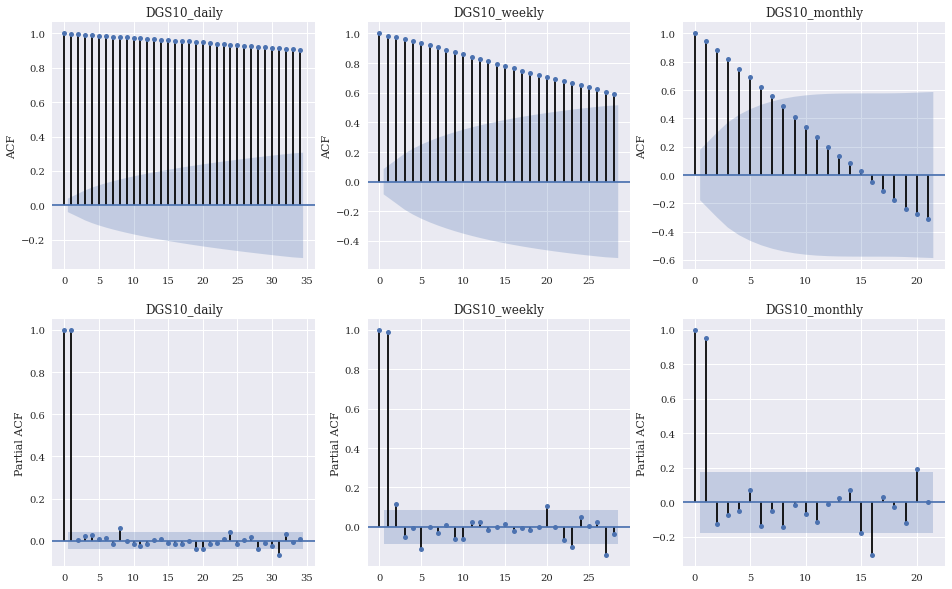

In [23]:
acf_pacf_plot(DGS10_daily, DGS10_weekly, DGS10_monthly)

The high first-order auto-correlation suggests that the time series has a unit root on every periodicity (daily, weekly and monthly).

### Conduct Augmented Dickey-Fuller Test for Unit Roots

It is essential to determine whether the time series is "stationary". Informally, stationarity is when the auto-covariance is independent of time. Failure to establish stationarity will almost certainly lead to misinterpretation of model identification and diagnostics tests. 

We perform an Augmented Dickey-Fuller test to establish stationarity under the assumption that the time series has a constant bias but does not exhibit a time trend. In other words, we assume that the time series is already de-trended. 

If the stationarity test fails, even after first de-trending the time series, then one potential recourse is to simply take differences of time series and predict $\Delta y_t$.

For each periodicity, apply the function adfuller() twice:
-  to the un-differenced series (null hypothesis: input series has a unit root)
-  to the first-differenced series (same null hypothesis about differenced series)

Results for the un-differenced series:

In [24]:
DGS10_weekly

,DGS10_weekly
Date,
2011-10-23,2.23
2011-10-30,2.34
2011-11-06,2.06
2011-11-13,2.04
2011-11-20,2.01
...,...
2021-09-19,1.37
2021-09-26,1.47
2021-10-03,1.48


In [25]:
print(sm.tsa.adfuller(DGS10_daily['DGS10_daily'])[1])

0.38133527878417517


In [26]:
print(sm.tsa.adfuller(DGS10_weekly['DGS10_weekly'])[1])

0.4663384684155049


In [27]:
print(sm.tsa.adfuller(DGS10_monthly['DGS10_monthly'])[1])

0.42416021367886364


For each periodicity, the null hypothesis of a unit root for the time series DGS10 is not rejected at the 0.05 level. The p-value for each test does not fall below standard critical values of 0.05 or 0.01.
The p-value is the probability (assuming the null hypothesis is true) of realizing a test statistic as extreme as that computed for the input series. Smaller values (i.e., lower probabilities) provide stronger evidence against the null hyptohesis.
The p-value decreases as the periodicity of the data shortens. This suggests that the time-series structure in the series DGS10 may be stronger at higher frequencies.

Results for the first-differenced series:

In [28]:
print(sm.tsa.adfuller((DGS10_daily.shift(1)-DGS10_daily).dropna()['DGS10_daily'])[1])

0.0


In [29]:
print(sm.tsa.adfuller((DGS10_weekly.shift(1)-DGS10_weekly).dropna()['DGS10_weekly'])[1])

0.0


In [30]:
print(sm.tsa.adfuller((DGS10_monthly.shift(1)-DGS10_monthly).dropna()['DGS10_monthly'])[1])

1.5067346413036143e-17


For each of the three time periodicities, the ADF test rejects the null hypothesis that a unit root is present for the first-differenced series.

### The ACF and PACF for the differenced series of each periodicity

One application of the operator $(1 − B)$ produces a new series $\{Y_t\}$ with no obvious deviations from stationarity.

In [31]:
diff_DGS10_daily = (DGS10_daily.shift(1)-DGS10_daily).dropna()
diff_DGS10_daily.columns = ['diff_DGS10_daily']
diff_DGS10_weekly = (DGS10_weekly.shift(1)-DGS10_weekly).dropna()
diff_DGS10_weekly.columns = ['diff_DGS10_weekly']
diff_DGS10_monthly = (DGS10_monthly.shift(1)-DGS10_monthly).dropna()
diff_DGS10_monthly.columns = ['diff_DGS10_monthly']

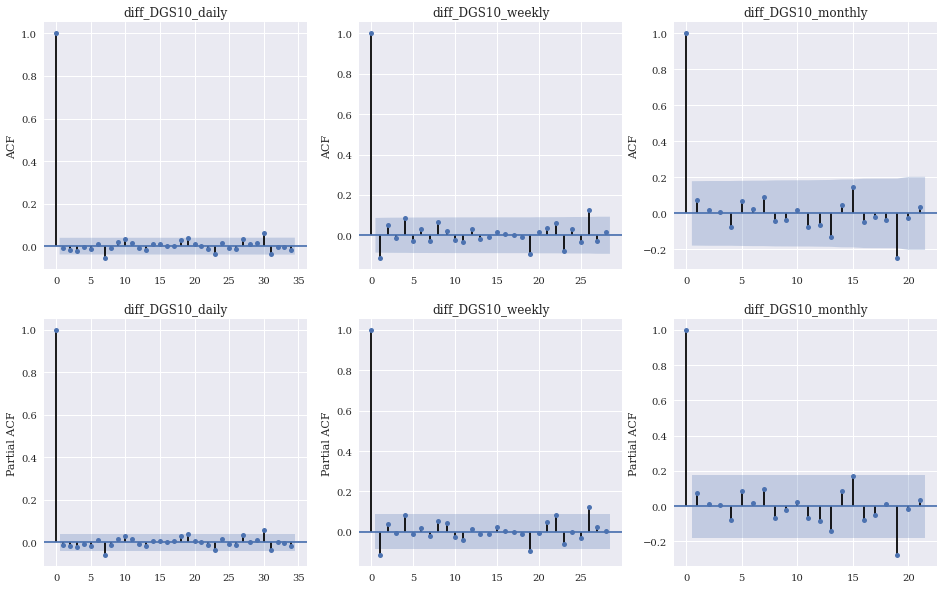

In [32]:
acf_pacf_plot(diff_DGS10_daily, diff_DGS10_weekly, diff_DGS10_monthly)

The apparent time series structure of DGS10 varies with the periodicity:

Daily:

    strong negative order-7 autocorrelation and partial autocorrelation
    strong positive order-30 autocorrelation and partial autocorrelation

Weekly:

    strong negative order-1 autocorrelation and partial autocorrelation
    strong positive order-26 autocorrelation and partial autocorrelation
    
Monthly:

    strong negative order-19 autocorrelation and partial autocorrelation.

In [33]:
fig0 = px.line(DGS10_monthly, y='DGS10_monthly', height=400)
fig0.show();
fig1 = px.line(diff_DGS10_monthly, y='diff_DGS10_monthly', height=300)
fig1.show();

The differenced series diff_DGS10_monthly crosses the level 0.0 many times over the historical period. There does not appear to be a tendency for the differenced series to stay below (or above) the zero level. The series appears consistent with covariance-stationary time series structure but whether the structure is other than white noise can be evaluated by evaluating AR(p) models for p = 0, 1, 2, ... and determining whether an AR(p) model for p > 0 is identified as better than an AR(0), i.e., white noise.

### The best AR(p) model for monthly data using the AIC criterion

In [34]:
warnings.filterwarnings("ignore")
# Define the d and q parameters to take any value between 0 and 1
p = range(0, 25)

AIC = []
AR_model = []
for param in p:
    try:
        model = AutoReg(diff_DGS10_monthly.values, param)
        results = model.fit()
        print('AR({}) - AIC:{}'.format(param, results.aic), end='\r')
        AIC.append(results.aic)
        AR_model.append([param])
    except:
        continue


In [35]:
print('The smallest AIC is {} for model AR({})'.format(min(AIC), 
            AR_model[AIC.index(min(AIC))][0]))

The smallest AIC is -3.2368803775598853 for model AR(0)


In [36]:
# Let's fit this model
model = AutoReg(diff_DGS10_monthly.values, 0)

results = model.fit()

In [37]:
print(results.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  120
Model:                     AutoReg(0)   Log Likelihood                  25.940
Method:               Conditional MLE   S.D. of innovations              0.195
Date:                Wed, 09 Feb 2022   AIC                             -3.237
Time:                        19:02:07   BIC                             -3.190
Sample:                             0   HQIC                            -3.218
                                  120                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0048      0.018      0.272      0.786      -0.030       0.040


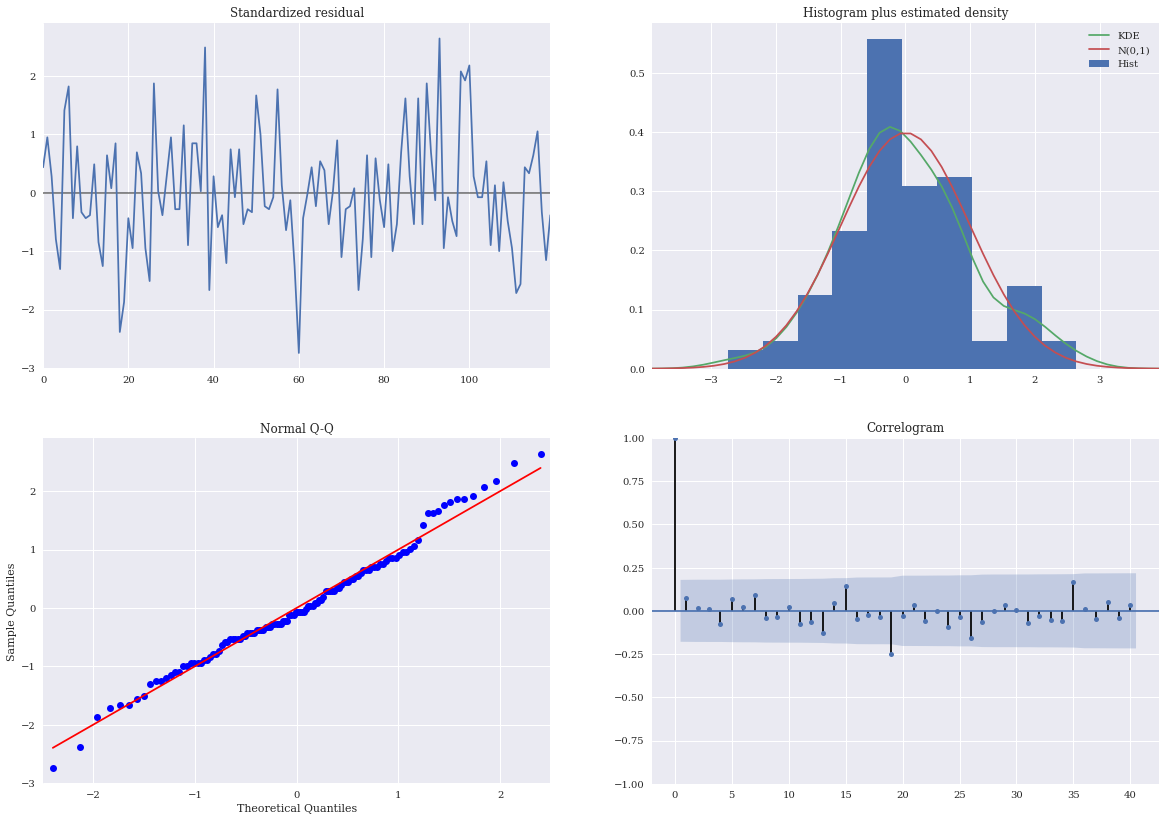

In [38]:
results.plot_diagnostics(lags=40, figsize=(20, 14))
plt.show()

In the plots above, we can observe that the residuals are uncorrelated (bottom right plot) and do not exhibit any obvious seasonality (the top left plot). Also, the residuals and roughly normally distributed with zero mean (top right plot). The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) roghly follows the linear trend of samples taken from a standard normal distribution with $N(0, 1)$. Again, this is a strong indication that the residuals are normally distributed.

We conclud that the best model for differenced data is AR(0), i.e., white noise. Thus for the original data the model is $X_t = 0.0048 + X_{t-1}+Z_t$, where $Z_t \sim WN(0,\sigma^2)$. The parameter $\sigma^2$ may be estimated by equating the sample ACVF with the model ACVF at lag 0.

In [39]:
sm.tsa.stattools.acovf(diff_DGS10_monthly.values, nlag=0)

array([0.03799831])

Using the approximate solution $\sigma^2 = 0.04$, we obtain the following model

$$
X_t = 0.0048 + X_{t-1}+Z_t, \ \ Z_t \sim WN(0,0.04).
$$

### The best AR(p) model for weekly data

In [40]:
warnings.filterwarnings("ignore")
# Define the p parameter to take any value between 0 and 25
p = range(0, 25)

AIC = []
AR_model = []
for param in p:
    try:
        model = AutoReg(diff_DGS10_weekly.values, param)
        results = model.fit()
        print('AR({}) - AIC:{}'.format(param, results.aic), end='\r')
        AIC.append(results.aic)
        AR_model.append([param])
    except:
        continue


In [41]:
print('The smallest AIC is {} for model AR({})'
      .format(min(AIC), AR_model[AIC.index(min(AIC))][0]))

The smallest AIC is -4.624547948917449 for model AR(2)


In [42]:
# Let's fit this model
model = AutoReg(diff_DGS10_weekly.values, 2)

results = model.fit()

In [43]:
print(results.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  521
Model:                     AutoReg(2)   Log Likelihood                 467.641
Method:               Conditional MLE   S.D. of innovations              0.098
Date:                Wed, 09 Feb 2022   AIC                             -4.625
Time:                        19:02:08   BIC                             -4.592
Sample:                             2   HQIC                            -4.612
                                  521                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0010      0.004      0.230      0.818      -0.007       0.009
y.L1          -0.1028      0.044     -2.361      0.018      -0.188      -0.017
y.L2           0.0392      0.044      0.900      0.3

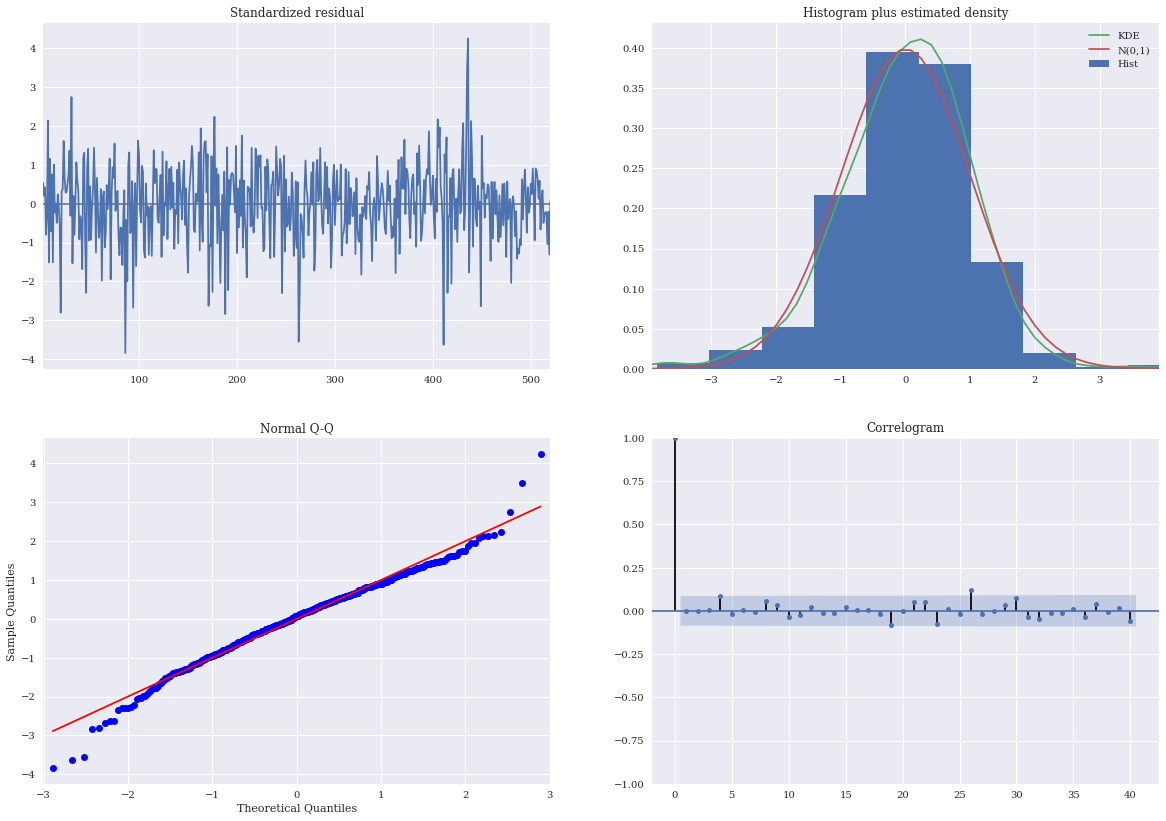

In [44]:
results.plot_diagnostics(lags=40, figsize=(20, 14));

The residuals are consistent with their expected behavior under the model.

### Evaluating the stationarity and cyclicality of the fitted AR(2) model to weekly data

To show the stationarity we have to show that all roots of characteristic polynomial lie outside the unit circle

$$
\phi(z) = 1-\phi_1 z-\phi_2 z^2 \neq 0 \ \ \text{for all} \ |z|=1.
$$

From summarize of the Auto Regression model results we have estimates $\hat\phi_1 = -0.1$ and $\hat\phi_2 = 0.04$.

In [45]:
phi_1 = -0.1
phi_2 = 0.04

In [46]:
# np.polyroots() method is used to compute the roots of a polynomial 

np.polynomial.polynomial.polyroots((1, phi_1, phi_2))

array([1.25-4.84122918j, 1.25+4.84122918j])

Both roots are complex located outside the unit circle, we conclud that the fitted model is stationary.

In [47]:
# With complex roots, there is evidence of cyclicality in the series
# The following computation computes the period as it is determined by the
# coefficients of the characteristic polynomial.

twopif=np.arccos( abs(results.params[1])/(2*np.sqrt(results.params[2])))
f=twopif/(8*np.arctan(1))
period=-1/f
print(period)

-4.802817275323328


In [48]:
# The data are consistent with cycle of period just over 5 weeks.

 Yule–Walker estimator for $\sigma^2$:
 $$
 \hat\sigma^2 = \hat\gamma(0)-\hat\phi_1\hat\gamma(1)-\hat\phi_2\hat\gamma(2)
 $$

In [49]:
sigma = sm.tsa.stattools.acovf(diff_DGS10_weekly.values, nlag=2)[0] - \
phi_1*sm.tsa.stattools.acovf(diff_DGS10_weekly.values, nlag=2)[1] -  \
phi_2*sm.tsa.stattools.acovf(diff_DGS10_weekly.values, nlag=2)[2]

In [50]:
print('sigma^2=', sigma)

sigma^2= 0.009790649932310859


Finally we conclude for differenced weekly times series

$$
Y_t =0.001 -0.1Y_{t-1}+0.04Y_{t-2} + Z_t, \ \ \ Z_t \sim WN(0,0.01)
$$

and for weekly time series

$$
(1+0.1B-0.04B^2)(1-B)X_t =0.001 + Z_{t}, \ \ \ Z_t \sim WN(0,0.01).
$$